# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.



# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Исследовательский анализ данных

### Откроем и изучим файлы

In [1]:
! pip list | grep matplotlib

"grep" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [2]:
# импортируем необходимые библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time 
#import matplotlib.font_manager

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
#from matplotlib.font_manager import get_font_names
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

#### Данные об электродах

In [3]:
# открываем файл
data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

In [4]:
# выводим первые 5 строк
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [5]:
# смотрим частоту итераций в партии
data_arc['key'].value_counts()

2108    16
1513    15
1689    15
2567    14
46      13
        ..
112      1
2472     1
2025     1
3059     1
1615     1
Name: key, Length: 3214, dtype: int64

Видим что значения партии - key повторяются, этот показатель означает количество итериаций обработки материала в одной партии.
Видим что количество итераций в партиях разнится, полагаю на этапе предобработки нужна будет группировка по данному признаку.

In [6]:
# вывод общей информации
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Видим что пропуски отсутствуют, тип данных в столбцах с временем начала и конца нагрева дугой необходимо изменить

In [7]:
# посмотри описательную статистику
data_arc.describe().T

,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
Реактивная мощность,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


In [8]:
#вывод строк в которых реактивная мощность меньше нуля
data_arc[data_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Видим что отрицательное значение в столбце с реактивной мощностью всего одно, предлагаю удалить его на этапе предобработки

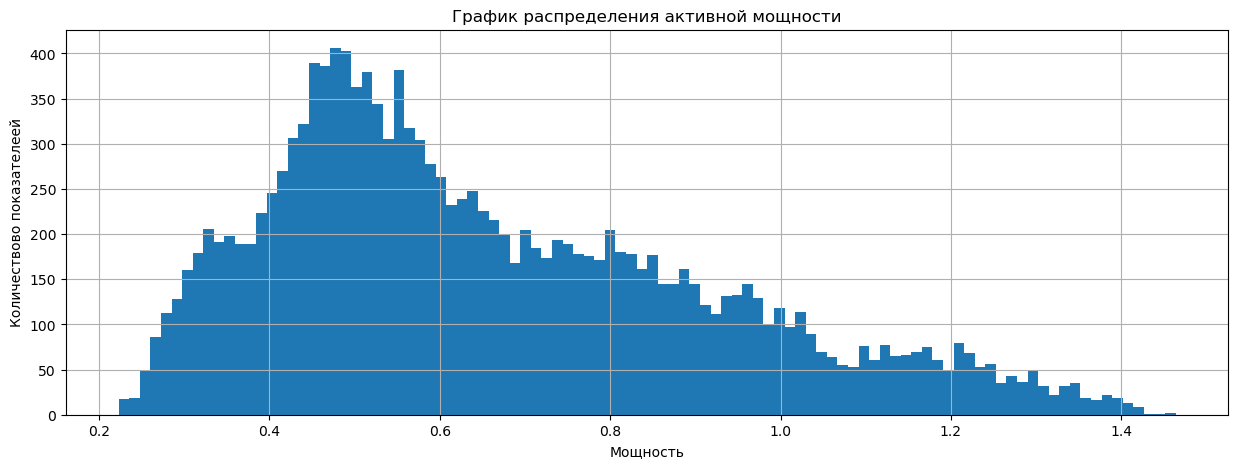

In [9]:
# посмотрим распределение признака Активная мощность
data_arc['Активная мощность'].hist(bins=100,figsize=(15, 5))
plt.title('График распределения активной мощности')
plt.xlabel("Мощность")
plt.ylabel("Количествово показателеей")
plt.show()

Нормальное распределение активной мощности

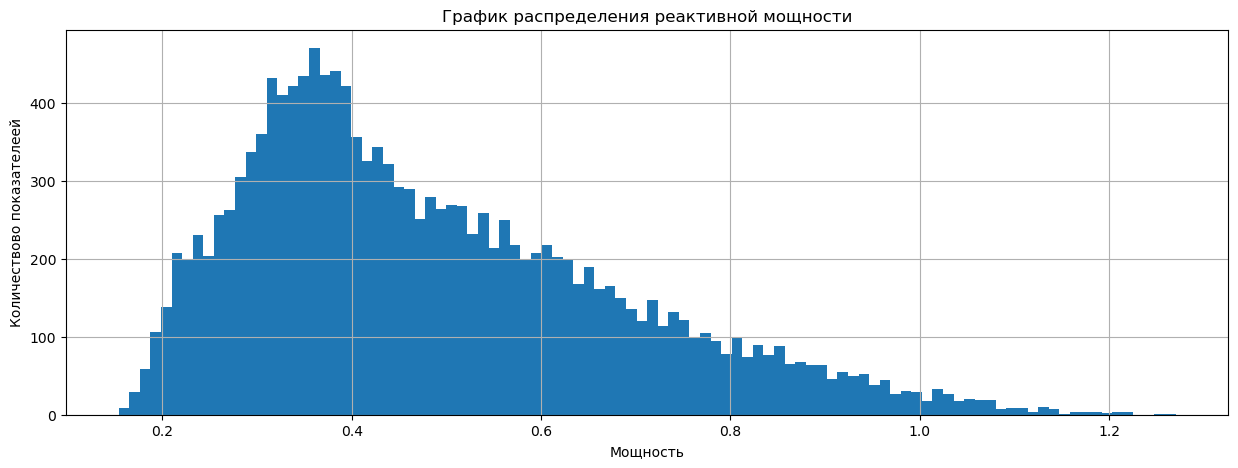

In [10]:
# посмотрим распределение признака Реактивная мощность
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100,figsize=(15, 5))
plt.title('График распределения реактивной мощности')
plt.xlabel("Мощность")
plt.ylabel("Количествово показателеей")
plt.show()

В таблице с данными об электродах:
- отстутствуют пропуски
- необходимо агрегирование данных по признаку key
- имеется отрицательное значение по признаку рекативная мощность, предлагаю избавиться
- необходимо именить тип данных в стобцах с временем начала и окончания нагрева дугой

#### Данные о подаче сыпучих материалов

##### Объем подачи сыпучих материалов

In [11]:
# открываем файл
data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

In [12]:
# выводим первые 5 строк
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
# вывод общей информации
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Видим достаточно большое количество пропусков, скорее всего просто на опредленном этапе не каждый материал добавлялся. Пропуски предлагаю заменить нулями на этапе предобработки, кроме того есть столбцы с маленьким количеством занчений, например Bulk 8 всего 1 значение, можно удалить данный столбец как неинформативный

In [14]:
# смотрим частоту итераций в партии
data_bulk['key'].value_counts()

1       1
2174    1
2152    1
2153    1
2154    1
       ..
1092    1
1093    1
1094    1
1095    1
3241    1
Name: key, Length: 3129, dtype: int64

Видим что в данной таблице нет повторяющихся значений

В таблице с данными об объеме подачи сыпучих материалов:
- большое количество пропусков, предлагаю заменить их 0
- есть неинформативные столбцы, в которых очень маленькое количесвто значений
- данные в стобце key уникальны

##### Время подачи сыпучих материалов

In [15]:
# открываем файл
data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

In [16]:
# выводим первые 5 строк
data_bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [17]:
# вывод общей информации
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Тип данных в столбцах с временем подачи сыпучих материалов необходимо изменить

В таблице с данными о времени подачи сыпучих материалов:
- большое количество пропусков
- есть неинформативные столбцы, в которых очень маленькое количесвто значений
- необходимо именить тип данных 

Таблица носит ознакомительный характер, для дальнейшей работы она нам не потребуется

#### Данные о продувке сплава газом

In [18]:
# открываем файл
data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

In [19]:
# выводим первые 5 строк
data_gas.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [20]:
# вывод общей информации
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [21]:
# смотрим частоту итераций в партии
data_gas['key'].value_counts()

1       1
2166    1
2156    1
2157    1
2158    1
       ..
1086    1
1087    1
1088    1
1089    1
3241    1
Name: key, Length: 3239, dtype: int64

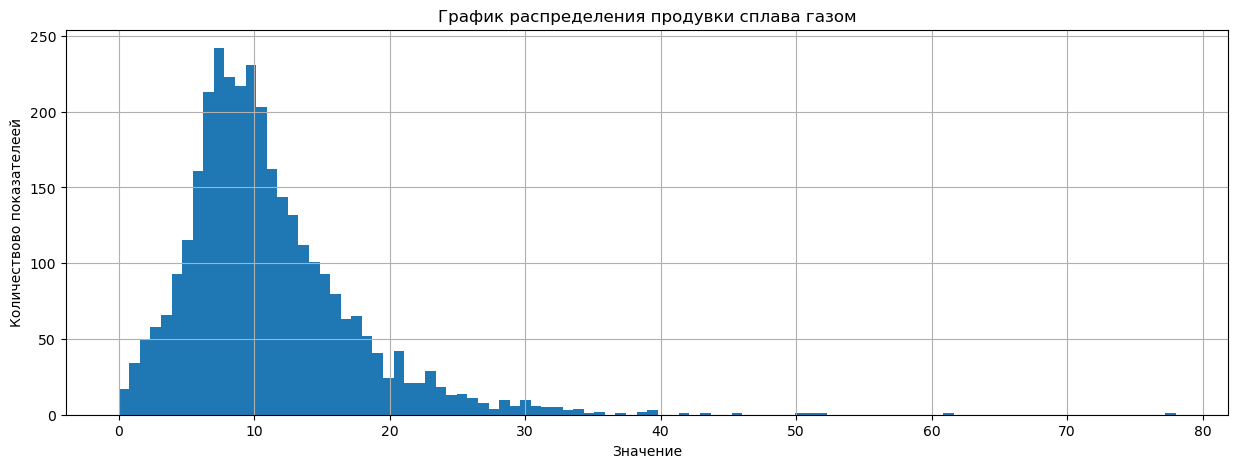

In [22]:
# посмотрим распределение признака Активная мощность
data_gas['Газ 1'].hist(bins=100,figsize=(15, 5))
plt.title('График распределения продувки сплава газом')
plt.xlabel("Значение")
plt.ylabel("Количествово показателеей")
plt.show()

В таблице с данными о продувке спалава газом:
- пропуски отсутствуют
- данные в стобце key уникальны

####  Результаты измерения температуры

In [23]:
# открываем файл
data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

In [24]:
# выводим первые 5 строк
data_temp.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [25]:
# вывод общей информации
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Можем наблюдать пропуски в столбце с данными температуры, кроме того тип данных в данном столбце необходимо изменить

In [26]:
# смотрим частоту итераций в партии
data_temp['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
46      14
        ..
247      2
1169     2
246      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

Видим что значения партии - key повторяются, на этапе предобработки нужна будет группировка по данному признаку.

In [27]:
# посмотри описательную статистику
data_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
Температура,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


Температура плавления стали в диапазоне: 1450—1520 °C, мы видим что есть значения ниже этих показателей

In [28]:
#вывод строк в которых температура плавления меньше нормативных значений
data_temp[data_temp['Температура'] <= 1450]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Видим что аномальных значений в столбце с температурой плавления не так много, предлагаю удалить их на этапе предобработки

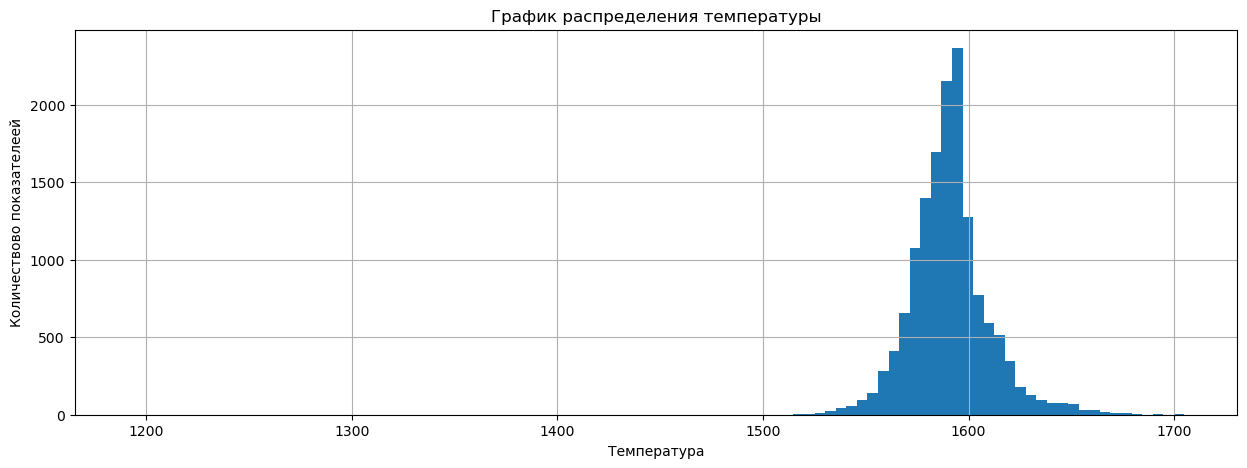

In [29]:
# посмотрим распределение признака Температура
data_temp['Температура'].hist(bins=100,figsize=(15, 5))
plt.title('График распределения температуры')
plt.xlabel("Температура")
plt.ylabel("Количествово показателеей")
plt.show()

В таблице с данными о результатах измерения температуры:
- имеются пропуски по температуре
- необходимо агрегирование данных по признаку key
- имеется аномально нгизкие температуры, предлагаю удалить данные партии на этапе предобработки
- необходимо изменить тип данных в стоблце с временем замера

#### Данные о проволочных материалах

##### Объем подачи проволочных материалов

In [30]:
# открываем файл
data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

In [31]:
# выводим первые 5 строк
data_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# вывод общей информации
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Видим достаточно большое количество пропусков, скорее всего материал не добавлялся. Пропуски предлагаю заменить нулями на этапе предобработки, кроме того есть столбцы с маленьким количеством занчений, например Wire 5 всего 1 значение, можно удалить данный столбец как неинформативный

In [33]:
# смотрим частоту итераций в партии
data_wire['key'].value_counts()

1       1
2226    1
2146    1
2147    1
2148    1
       ..
1090    1
1091    1
1092    1
1093    1
3241    1
Name: key, Length: 3081, dtype: int64

В таблице с данными об объеме подачи проволочных материалов:
- большое количество пропусков, предлагаю заменить их 0
- есть неинформативные столбцы, в которых очень маленькое количесвто значений
- данные в стобце key уникальны

##### Время подачи проволочных материалов

In [34]:
# открываем файл
data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [35]:
# выводим первые 5 строк
data_wire_time.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# вывод общей информации
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Тип данных в столбцах с временем подачи проволочных материалов необходимо изменить

В таблице с данными о времени подачи сыпучих материалов:
- большое количество пропусков
- есть неинформативные столбцы, в которых очень маленькое количесвто значений
- необходимо именить тип данных 

Таблица носит ознакомительный характер, для дальнейшей работы она нам не потребуется

## Предобработка данных

### Данные об электродах

In [37]:
# изменим тип данных в столбцах с временем начала и окончания нагрева дугой
data_arc['Начало нагрева дугой'] = data_arc['Начало нагрева дугой'].astype("datetime64")
data_arc['Конец нагрева дугой'] = data_arc['Конец нагрева дугой'].astype("datetime64")

In [38]:
# проверка результата
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [39]:
# удаляем данные по всей партии где была отрицательная мощность
data_arc = data_arc[data_arc['key'] != 2116]

In [40]:
# сгенерируем новый признак - длительность нагрева
data_arc['Длительность нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

In [41]:
# сгенерируем новый признак - энергия
data_arc['Энергия'] = data_arc['Активная мощность'] * data_arc['Длительность нагрева']

In [42]:
# агрегируем данные по ключу key просуммировав значени, оставим только данные с длительностью нагрева и энергией
data_arc_sum = data_arc.groupby('key').agg({'Длительность нагрева': 'sum', 'Энергия': 'sum'})
print(data_arc_sum.info())
data_arc_sum.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Длительность нагрева  3213 non-null   int64  
 1   Энергия               3213 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.3 KB
None


,Длительность нагрева,Энергия
key,,
1,1098,628.616930
2,811,395.281800
3,655,581.774624
4,741,543.710274
5,869,412.180480


### Данные о подаче сыпучих материралов

In [43]:
# заменим пропуски на 0
data_bulk.fillna(0, inplace=True)

In [44]:
# удалим неинформативный столбец
data_bulk = data_bulk.drop(columns = ['Bulk 8'],axis = 1)
print(data_bulk.info())
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 9   3129 non-null   float64
 9   Bulk 10  3129 non-null   float64
 10  Bulk 11  3129 non-null   float64
 11  Bulk 12  3129 non-null   float64
 12  Bulk 13  3129 non-null   float64
 13  Bulk 14  3129 non-null   float64
 14  Bulk 15  3129 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 366.8 KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


### Результаты измерения температуры

In [45]:
# изменим тип данных в столбце с временем замера
data_temp['Время замера'] = data_temp['Время замера'].astype("datetime64")

In [46]:
# проверка результата
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Предлагаю удалить те партии где были аномально низкие температуры, пропуски в данных и всего 1 замер температуры

In [47]:
#список партий в которых температура плавления меньше нормативных значений
drop_min = data_temp[data_temp['Температура'] <= 1450]['key'].tolist()

In [48]:
#список партий в которых только один замер температуры
one = data_temp['key'].value_counts().reset_index()
drop_one = one[one['key'] == 1]['index'].tolist()

In [49]:
#список партий в которых имеются пропуски в данных
drop_nan = data_temp[data_temp['Температура'].isna()]['key'].unique().tolist()

In [50]:
#удаление партий
data_temp = data_temp[~data_temp['key'].isin(drop_nan)]
data_temp = data_temp[~data_temp['key'].isin(drop_one)]
data_temp = data_temp[~data_temp['key'].isin(drop_min)]
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [51]:
#Целевым признаком является последняя измеренная температура, сгруппируем данные
data_temp_new = data_temp.groupby(by = 'key', as_index = False).agg(Начальная_температура = ( 'Температура','first'), 
                                                                    Конечная_температура = ( 'Температура','last'))

In [52]:
#проверка
print(data_temp_new .info())
data_temp_new .head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2471 non-null   int64  
 1   Начальная_температура  2471 non-null   float64
 2   Конечная_температура   2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.0 KB
None


,key,Начальная_температура,Конечная_температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


### Данные о проволочных материалах

In [53]:
# заменим пропуски на 0
data_wire.fillna(0, inplace=True)

In [54]:
# удалим неинформативный столбец
#data_wire = data_wire.drop(columns = ['Wire 5'],axis = 1)
print(data_wire.info())
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Подготовка данных

### Объединение данных в один датафрейм

In [55]:
# Объединение данных в один датафрейм
data_full = (
    data_temp_new.merge(data_arc_sum, how="inner", on="key")
    .merge(data_gas, how="inner", on="key")
    .merge(data_bulk, how="inner", on="key")
    .merge(data_wire, how="inner", on="key")
)

In [56]:
#Проверка результата
data_full.head()

,key,Начальная_температура,Конечная_температура,Длительность нагрева,Энергия,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,1098,628.616930,29.749986,0.0,0.0,0.0,43.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,811,395.281800,12.555561,0.0,0.0,0.0,73.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,655,581.774624,28.554793,0.0,0.0,0.0,34.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,741,543.710274,18.841219,0.0,0.0,0.0,81.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,869,412.180480,5.413692,0.0,0.0,0.0,78.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Исследуем датафрейм после объединения

In [57]:
# вывод общей информации
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2324 non-null   int64  
 1   Начальная_температура  2324 non-null   float64
 2   Конечная_температура   2324 non-null   float64
 3   Длительность нагрева   2324 non-null   int64  
 4   Энергия                2324 non-null   float64
 5   Газ 1                  2324 non-null   float64
 6   Bulk 1                 2324 non-null   float64
 7   Bulk 2                 2324 non-null   float64
 8   Bulk 3                 2324 non-null   float64
 9   Bulk 4                 2324 non-null   float64
 10  Bulk 5                 2324 non-null   float64
 11  Bulk 6                 2324 non-null   float64
 12  Bulk 7                 2324 non-null   float64
 13  Bulk 9                 2324 non-null   float64
 14  Bulk 10                2324 non-null   float64
 15  Bulk

Пропуски отсутствуют, тип данных соответствует значениям

In [58]:
# посмотри описательную статистику
data_full.describe().T

,count,mean,std,min,25%,50%,75%,max
key,2324.0,1251.140275,715.027927,1.000000,628.750000,1254.500000,1867.250000,2499.000000
Начальная_температура,2324.0,1587.368761,23.627590,1519.000000,1571.000000,1587.000000,1603.000000,1660.000000
Конечная_температура,2324.0,1593.372633,11.207457,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
Длительность нагрева,2324.0,808.196644,340.813828,57.000000,581.000000,778.000000,993.000000,4189.000000
Энергия,2324.0,539.381127,257.301093,26.187544,368.304687,508.538758,679.198659,3718.054401
Газ 1,2324.0,11.378854,6.397008,0.008399,7.282534,10.100687,14.218487,77.995040
Bulk 1,2324.0,3.435026,12.424463,0.000000,0.000000,0.000000,0.000000,185.000000
Bulk 2,2324.0,1.425559,19.102530,0.000000,0.000000,0.000000,0.000000,325.000000
Bulk 3,2324.0,47.317126,75.238050,0.000000,0.000000,0.000000,80.000000,454.000000
Bulk 4,2324.0,37.347676,58.677890,0.000000,0.000000,0.000000,77.250000,281.000000


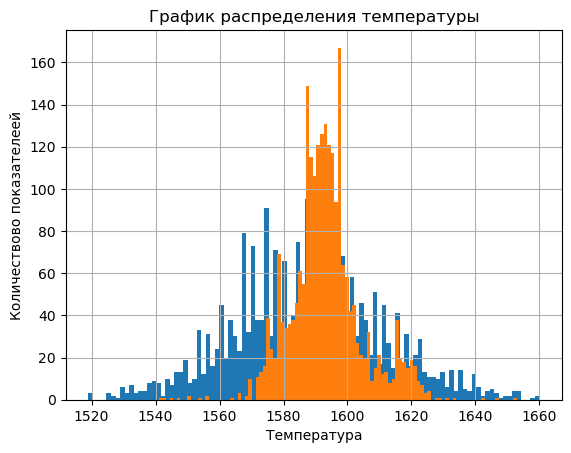

In [59]:
# посмотрим распределение признака Температура
figsize=(15, 5)
data_full['Начальная_температура'].hist(bins=100)
data_full['Конечная_температура'].hist(bins=100,)
plt.title('График распределения температуры')
plt.xlabel("Температура")
plt.ylabel("Количествово показателеей")
plt.show()

### Проверка на мультиколлинеарность

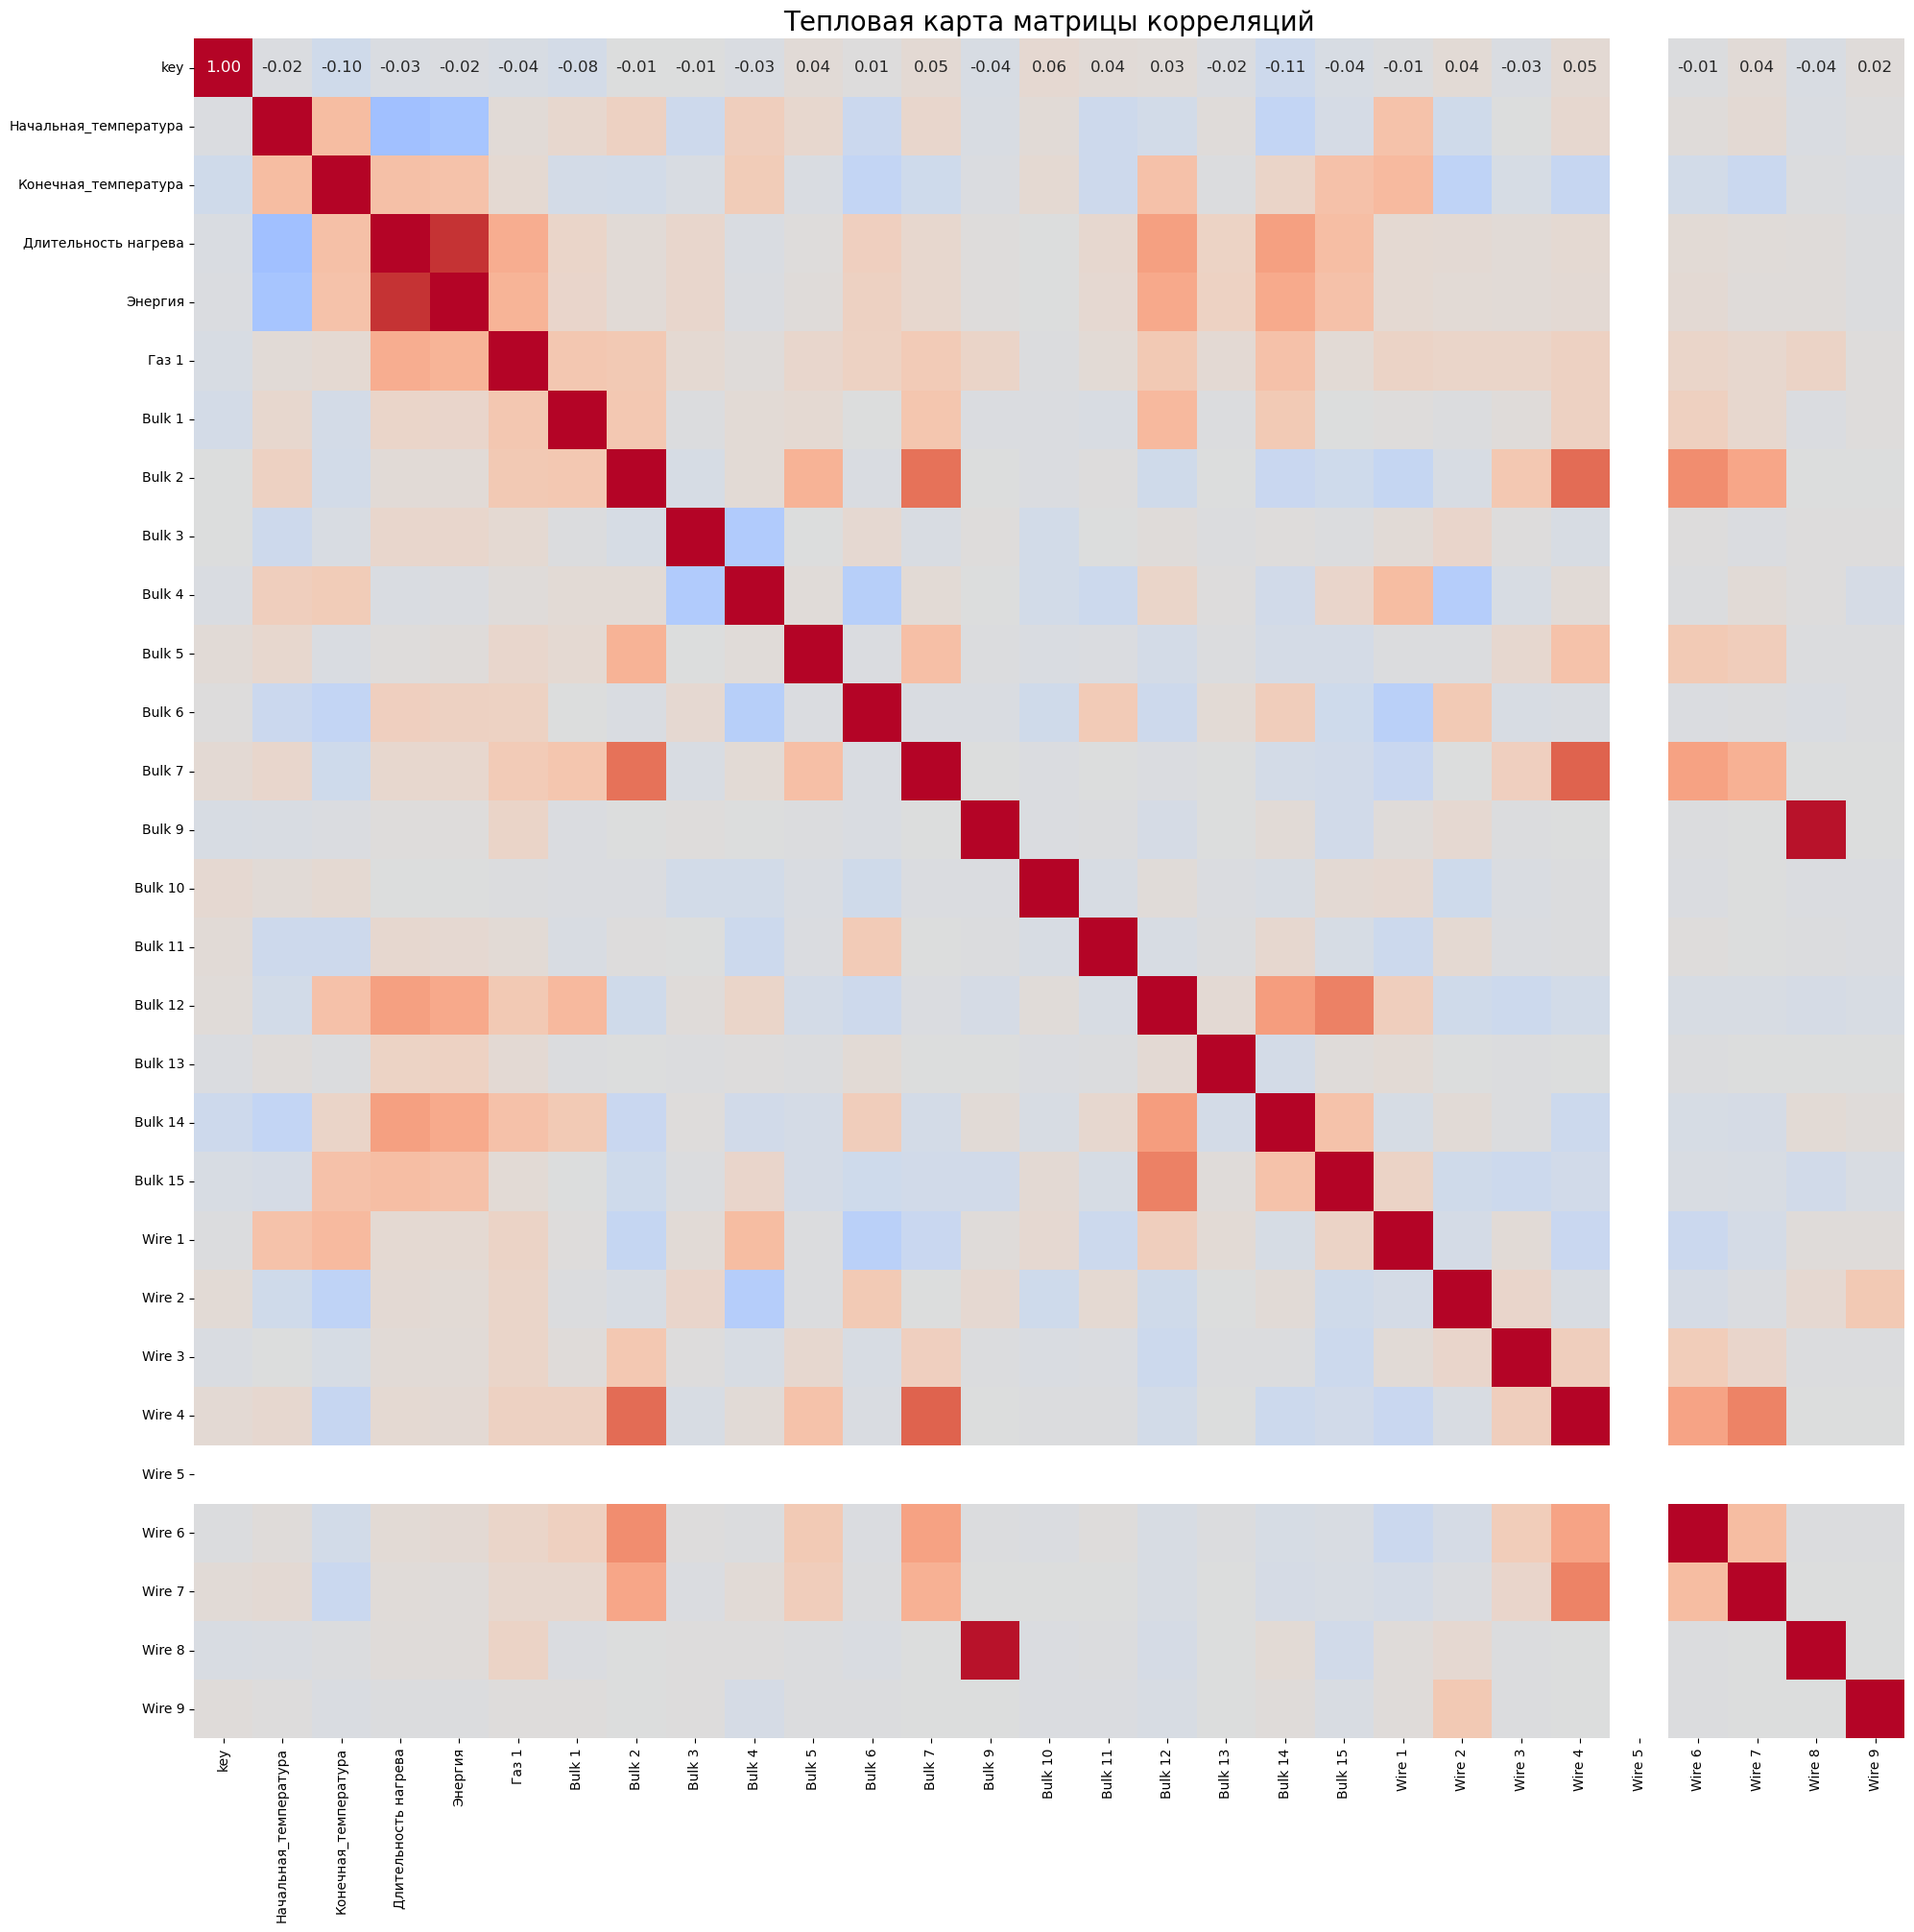

In [60]:
plt.figure(figsize=(23, 23))

a = sns.heatmap(data_full.corr(),
            annot=True,
            cmap= 'coolwarm',
            cbar=False,
            fmt='.2f',
            annot_kws={"fontsize": 12},
            vmin=-1,
            vmax=1)
a.set_title('Тепловая карта матрицы корреляций', fontsize=20)

plt.show()  
sns.reset_orig()

- Можем заметить сильную корреляцию следующих признаков - Энергия и длительность нагрева, что вполне логично. 
- Так же пряма зависимость наблюдается между Wire 8 и Bulk 9, удалим один из признаков. 
- Факторов сильно коррелирующих с целевым признаком нет.
- Так же предлагаю удалить столбец key

In [61]:
# удаляем признак
data_full = data_full.drop('Wire 8', axis=1)
data_full = data_full.drop('key', axis=1)

### Подготовка признаков к обучению

In [62]:
# фиксируем random_state
RANDOM_STATE = 110923

In [63]:
 # Выделим признаки и целевой показатель
features = data_full.drop(columns=['Конечная_температура'], axis = 1)
target = data_full['Конечная_температура']

In [64]:
# Делим данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                                  random_state=RANDOM_STATE)
print('Размер обучающей выборки - ', features_train.shape, 'что составляет', 
      round(features_train.shape[0] / data_full.shape[0]*100,2), '% от исходного')
print('Размер тестовой выборки - ',  features_test.shape, 'что составляет', 
      round(features_test.shape[0] / data_full.shape[0]*100,2), '%  от исходного')

Размер обучающей выборки -  (1743, 26) что составляет 75.0 % от исходного
Размер тестовой выборки -  (581, 26) что составляет 25.0 %  от исходного


In [65]:
# Масштабирование признаков
# создание и настройка StandardScaler на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train) 

 # стандартизируем признаки
feature_train = scaler.transform(features_train)
feature_test= scaler.transform(features_test)

## Обучение моделей

###  LightGBM 

In [66]:
%%time

# построим модель
start_l = time.time()
model_l = LGBMRegressor(random_state=RANDOM_STATE)
parameters_l = {'num_leaves':[x for x in range(5,25)],
                'learning_rate': [0.01, 0.05, 0.1]}
random_l = RandomizedSearchCV(estimator=model_l,
                              param_distributions=parameters_l,
                              n_iter=10,  
                              scoring='neg_mean_absolute_error',  
                              cv=5,  
                              verbose=2,
                              random_state=RANDOM_STATE,
                              n_jobs=-1)
random_l.fit(feature_train, target_train)
end_l = time.time()
t_l=round(end_l-start_l,2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2213
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 18
[LightGBM] [Info] Start training from score 1593.332186
Wall time: 6.39 s


In [67]:
# параметры, МАЕ
print('Лучшие параметры LightGBM - ', random_l.best_params_)
print('MAE LightGBM - ',round(random_l.best_score_,4)*(-1))

Лучшие параметры LightGBM -  {'num_leaves': 8, 'learning_rate': 0.05}
MAE LightGBM -  6.1854


### CatBoostRegressor

In [68]:
%%time

# построим модель
start_c = time.time()
model_c = CatBoostRegressor() 
parameters_c = {'learning_rate':[0.1, 0.5, 0.8],
                'depth': [3, 4]} 
random_c = RandomizedSearchCV(estimator=model_c,
                              param_distributions=parameters_c,
                              n_iter=10,  
                              scoring='neg_mean_absolute_error',  
                              cv=5,  
                              verbose=2,
                              random_state=RANDOM_STATE,
                              n_jobs=-1)
random_c.fit(feature_train, target_train)
end_c = time.time()
t_c=round(end_c-start_c,2)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 10.8771845	total: 139ms	remaining: 2m 18s
1:	learn: 10.6705433	total: 143ms	remaining: 1m 11s
2:	learn: 10.4718622	total: 148ms	remaining: 49s
3:	learn: 10.2989204	total: 152ms	remaining: 37.8s
4:	learn: 10.1006732	total: 156ms	remaining: 31s
5:	learn: 9.9208942	total: 160ms	remaining: 26.6s
6:	learn: 9.7854076	total: 164ms	remaining: 23.3s
7:	learn: 9.6696934	total: 168ms	remaining: 20.8s
8:	learn: 9.5665728	total: 173ms	remaining: 19s
9:	learn: 9.4222627	total: 177ms	remaining: 17.5s
10:	learn: 9.3396878	total: 181ms	remaining: 16.3s
11:	learn: 9.2613616	total: 185ms	remaining: 15.2s
12:	learn: 9.1844147	total: 189ms	remaining: 14.3s
13:	learn: 9.0931545	total: 194ms	remaining: 13.6s
14:	learn: 9.0143637	total: 198ms	remaining: 13s
15:	learn: 8.9521747	total: 202ms	remaining: 12.5s
16:	learn: 8.8729084	total: 206ms	remaining: 11.9s
17:	learn: 8.8218476	total: 210ms	remaining: 11.5s
18:	learn: 8.7702039	total: 214ms

In [69]:
# параметры, МАЕ
print('Лучшие параметры CatBoostRegressor - ', random_c.best_params_)
print('MAE CatBoostRegressor - ',round(random_c.best_score_,4)*(-1))

Лучшие параметры CatBoostRegressor -  {'learning_rate': 0.1, 'depth': 4}
MAE CatBoostRegressor -  6.4226


### LinearRegression

In [70]:
%%time
# построим модель
start_lr = time.time()
model_lr = LinearRegression()
parameters_lr = {'n_jobs':[8, 10]} 
random_lr = RandomizedSearchCV(estimator=model_lr,
                              param_distributions=parameters_lr,
                              n_iter=10,  
                              scoring='neg_mean_absolute_error',  
                              cv=5,  
                              verbose=2,
                              random_state=RANDOM_STATE,
                              n_jobs=-1)
random_lr.fit(feature_train, target_train)
end_lr = time.time()
t_lr=round(end_lr-start_lr,2)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 257 ms


In [71]:
# параметры, МАЕ
print('Лучшие параметры LinearRegression - ', random_lr.best_params_)
print('MAE LinearRegression - ',round(random_lr.best_score_,4)*(-1))

Лучшие параметры LinearRegression -  {'n_jobs': 8}
MAE LinearRegression -  6.3233


### Bыбор лучшей модели

In [72]:
# выбор лучшей модели
column=['Скорость обучения', 'MAE']

summary = pd.DataFrame(index=column, columns=['LGBMRegressor','CatBoostRegressor','LinearRegression'])
summary['LGBMRegressor'] = t_l,  round(random_l.best_score_,4)*(-1)
summary['CatBoostRegressor'] = t_c, round(random_c.best_score_,4)*(-1)
summary['LinearRegression'] = t_lr, round(random_lr.best_score_,4)*(-1)
summary.T

,Скорость обучения,MAE
LGBMRegressor,6.39,6.1854
CatBoostRegressor,46.58,6.4226
LinearRegression,0.26,6.3233


В ходе проделанной работы на данном этапе мы выяснили что наименьшая ошибка - 6.1854 у модели LightGBM с гиперапраметрами learning_rate=0.05, num_leaves=21 время обучения данной модели примерно 5 секунд

###  Исследование важности признаков лучшей моделии

In [73]:
# исследование важности признаков
random_l.fit(features_train, target_train)
feature_importances = random_l.best_estimator_.feature_importances_
col = list(features_train.columns)
feature_importances_df = pd.DataFrame({'feature': col,
                                       'importance': feature_importances}).sort_values('importance',
                                                                                       ascending = False)
feature_importances_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2276
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 18
[LightGBM] [Info] Start training from score 1593.332186


,feature,importance
0,Начальная_температура,109
1,Длительность нагрева,76
18,Wire 1,45
3,Газ 1,44
9,Bulk 6,31
2,Энергия,30
16,Bulk 14,29
4,Bulk 1,24
19,Wire 2,23
14,Bulk 12,20


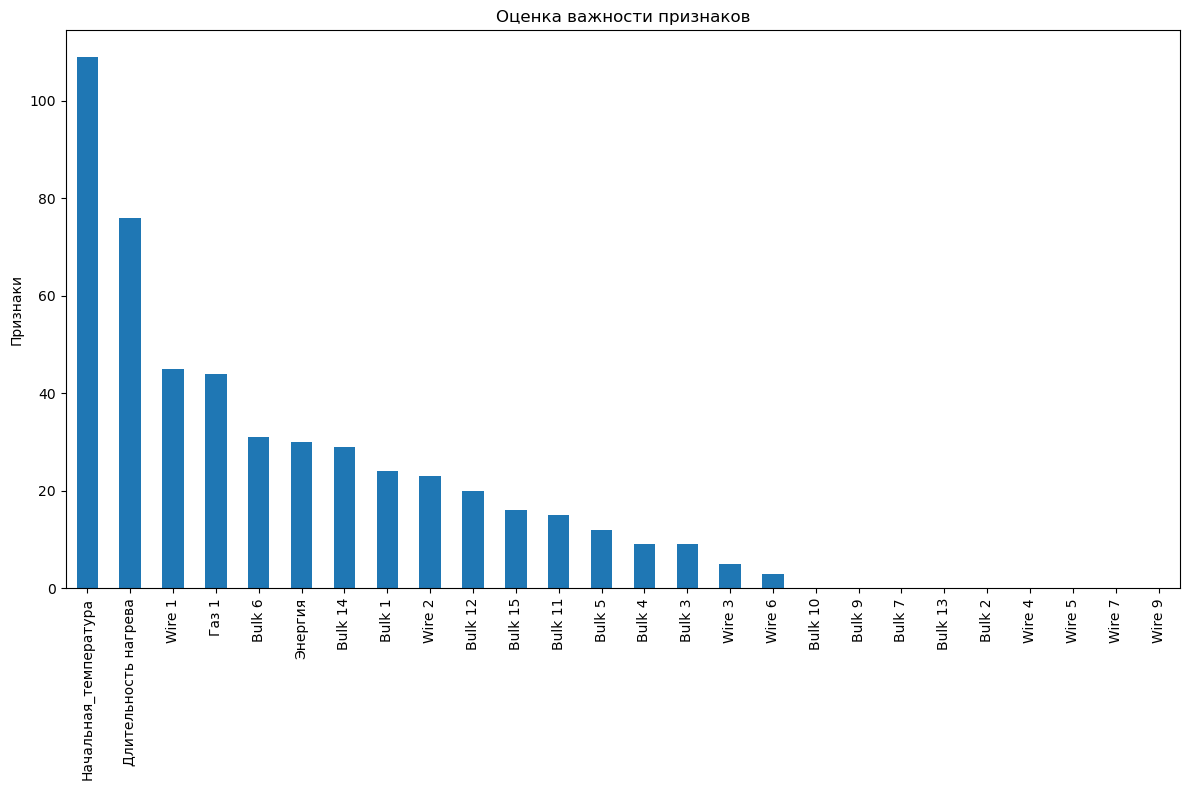

In [74]:
# визуализируем данные
feature_imp = pd.Series(random_l.best_estimator_.feature_importances_, 
                        index=features_train.columns).sort_values(ascending=False)
      
fig, ax = plt.subplots(figsize=(12,8))
feature_imp.plot.bar(ax=ax)
_ = ax.set_title('Оценка важности признаков')
_ = ax.set_ylabel('Признаки')
fig.tight_layout()
plt.show()

Наиболее важными признаками для модели являются начальная температура и длительность нагрева

## Тестирование модели

In [75]:
%%time
# получим предсказания
predict_l = random_l.best_estimator_.predict(features_test)

Wall time: 12.8 ms


In [76]:
# MAE
mae_l = mean_absolute_error(target_test, predict_l) 
print('MAE LightGBM на тестовой выборке - ', round(mae_l,2))

MAE LightGBM на тестовой выборке -  6.53


In [77]:
print("R2 score:", round(r2_score(target_test, predict_l),2))

R2 score: 0.37


Наша модель предсказывает примерно 37% изменчиаости в данных. Не самый лучший результат, но это лучше чем просто предсказание среднего значения целевой переменной,  в таком случае R2 была бы равно нулю.

Чтобы оценить адекватность модели нужно сравнить ее с константной 

In [78]:
# оценка константной модели
model_dr = DummyRegressor(strategy="mean")
model_dr.fit(features_train, target_train) 
predict_dr = model_dr.predict(features_test)
mae_dr = mean_absolute_error(target_test, predict_dr) 
print('MAE константной  модели :', round(mae_dr,2))

MAE константной  модели : 8.16


Как видим, наша модель лучше наивного прогноза

## Отчет

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нашей задачей было построить модель, которая предскажет температуру стали, и мы удачно справились с поставленной задачей.

Был составлен план работы  и в прпоцессе решения поставленной задачи мы полностью придерживались заданного плана.

Как таковых трудностей в процессе реализации проекта не возникало, поскольку от заказчика было получено достаточное колличество информации.  
Были выявлены, и оперативно устранены следующие моменты:
- в некоторых полях было несоответствие типа данных, мы их привели к необходимому формату
- отрицательное значение в столбце с реактивной мощностью, была удалена вся партия с некорректными данными
- большое количество пропусков в таблицах с информацией о подаче сыпучих и проволочных материалов, пропуски были заменены 0
- в таблице с результатами измерения температуры были оьбнаружены пропуски в замерах, единичные замеры, а так же такие показатели температуры, ниже той при которой плавится сталь все партии с такими замерами были удалены

В процессе решения поставленной задачи были выполнены следующие ключевые шаги:
- проведен исследовательский анализ и предобработка данных:
    - в таблице с данными об электродах - изменили тип данных, удалили данные по всей партии где была отрицательная мощность, вычислили энергию и длительность нагрева, сформировали агрегированную по ключу таблицу
    - в таблице с данными об объеме подачи сыпучих материалов - пропуски заменили нулями, удалили неинформативный столбец Bulk 8, в котором было всего 1 значение
    -  в таблице с данными о результатах измерения температуры - изменили тип данных, удалили данные по всей партии где была аномально низкая температура, пропуски в данных и всего 1 замер температуры, вычислили начальную и конечную температуру, сформировали агрегированную по ключу таблицу
    - в таблице с данными об объеме проволочных материалов - пропуски заменили нулями, удалили неинформативный столбец Wire 5, в котором было всего 1 значение
- после чего данные были объеденены в один датафрейм, проверка полученных данных на мультиколениарность показала следующее:
    - выявлена сильная взаимосвязь следующих признаков - энергия и длительность нагрева, что вполне логично
    - прямая зависимость между признаками Wire 8 и Bulk 9, удалили один из признаков
    - факторов сильно коррелирующих с целевым признаком не выявлено
    
Целевым признаком по условию задачи является последний замер температуры, для решения поставленной задачи мы сгенерировали новые признаки - энергия, длительность нагрева, начальная и конечная температура

Были обучены следующие модели, подбор гиперпарамотров для которых осуществялся с помощью RandomizedSearchCV:
- LGBMRegressor,  наилучший результат для данной модели при котором МАЕ была равна 6,1854 дали следующие гиерпараметры:
    - num_leaves = 8
    - learning_rate = 0.05
    - random_state =  110923
- CatBoostRegressor, наилучший результат для данной модели при котором МАЕ была равна 6,3645 дали следующие гиерпараметры:
    - depth = 3
    - learning_rate = 0.1
    - random_state =  110923
- LinearRegression, наилучший результат для данной модели при котором МАЕ была равна 6,3233 дали следующие гиерпараметры:
    - n_jobs =8
    - random_state =  110923
Лучше всего себя показала модель LGBMRegressor, на тесте модель LightGBM с гиперапраметрами learning_rate=0.05, num_leaves=8 дала значение МАЕ 6.53, что соответствует условиям. Модель можно считать успешной.

Кроме того было проведено иследование важности признаков лучшей модели, и выявлено что наиболее важными признаками для модели являются начальная температура и длительность нагрева